In [1]:
import os
import numpy as np
import sklearn.metrics
from sklearn.neighbors import KNeighborsClassifier
import torch.nn as nn
import torch.utils.data
from torch.utils.data import DataLoader
import kcu as utils
import time
import pandas as pd
from tpot import TPOTClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from matplotlib import pyplot as plt
from sklearn import decomposition
from sklearn.manifold import TSNE
import seaborn as sns
from kcu import capsules
import torch.optim as optim
from tqdm import tqdm


""" SETUP """
dry_run = True
cwdir = os.getcwd()
trainfile = cwdir + "/../../data/MNIST/train.csv"
df = pd.read_csv(trainfile)

train_data = df.to_numpy()
train_Y = train_data[:, 0]
train_X = train_data[:, 1:]

# Split train set into train and validation
train_inds, val_inds = sklearn.model_selection.train_test_split(
    np.arange(len(train_Y)), test_size=0.2
)
train_X, val_X = train_X[train_inds], train_X[val_inds]
train_Y, val_Y = train_Y[train_inds], train_Y[val_inds]

if dry_run:
    train_X, train_Y = train_X[:1024], train_Y[:1024]

#timings = utils.boilerplates.time_classifiers(train_X, train_Y)
#sns.lineplot(data=timings, x="samples", hue="method", y="time")
#plt.show()

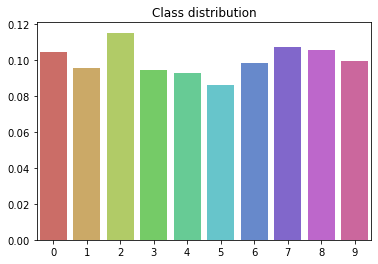

In [2]:
""" DATA EXPLORATION """
# Visualize class distribution
utils.visualization.show_class_distribution(train_Y)

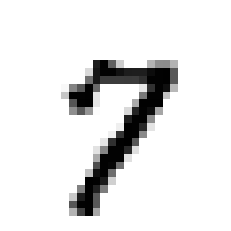

In [3]:
# As we know this is 2D image data, visualize some samples:
plt.imshow(train_X[0].reshape(28, 28), cmap="binary")
plt.axis("off")
plt.show()

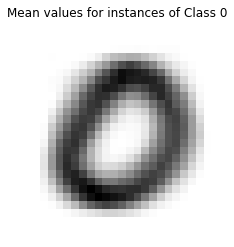

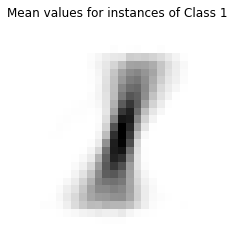

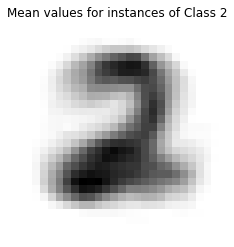

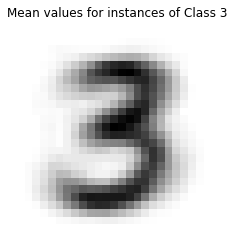

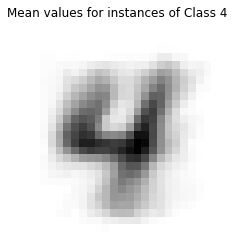

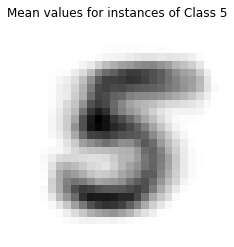

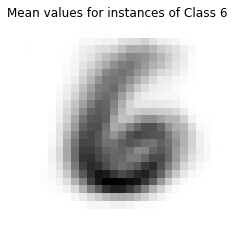

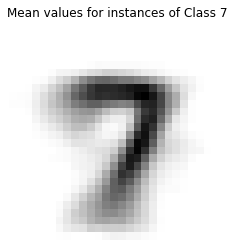

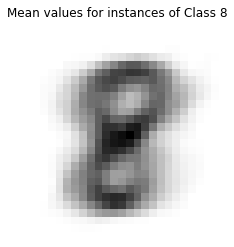

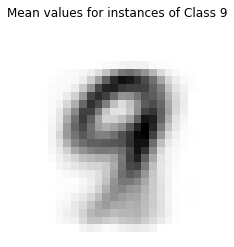

In [4]:
# Show an average of multiple instances from same class (class 1)
for i in range(10):
    inds = np.where(train_Y == i)
    acc = np.mean(train_X[inds], axis=0)
    plt.imshow(acc.reshape(28, 28), cmap="binary")
    plt.title("Mean values for instances of Class " + str(i))
    plt.axis("off")
    plt.show()

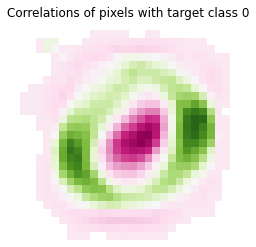

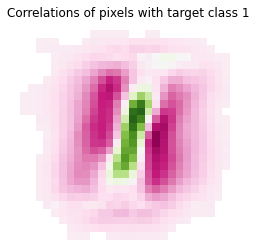

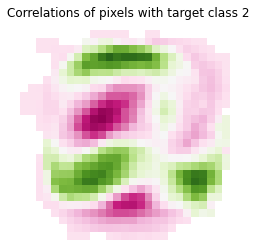

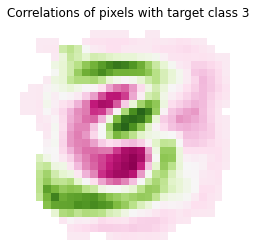

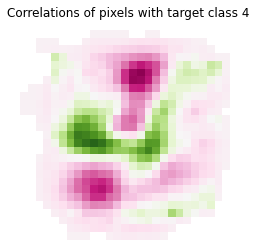

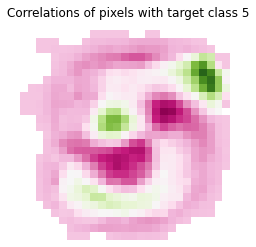

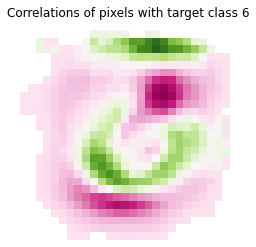

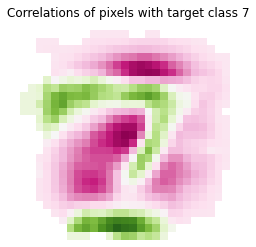

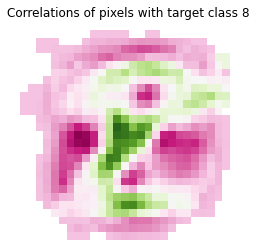

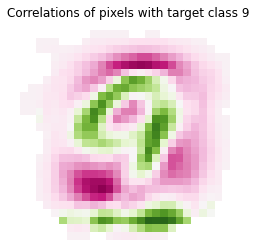

In [5]:
# Correlation analysis: for each class, lets identify important pixels first:
for i in range(10):
    new_Y = train_Y == i
    corr_coeff = pd.DataFrame(np.hstack([train_X, np.expand_dims(new_Y, 1)])).corr()[-1:].to_numpy()[0, :-1]
    plt.imshow(corr_coeff.reshape(28, 28), cmap="PiYG")
    plt.title("Correlations of pixels with target class " + str(i))
    plt.axis("off")
    plt.show()

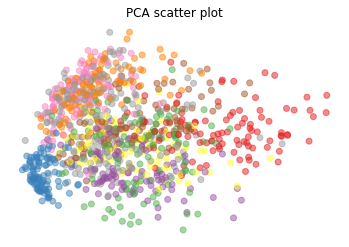

In [6]:
# Lets do PCA: identifying a good linear combination of features that maximize the total variance
pca = decomposition.PCA(n_components=2)
view = pca.fit_transform(train_X)
plt.scatter(view[:,0], view[:,1], c=train_Y, alpha=0.5, cmap='Set1')
plt.axis("off")
plt.title("PCA scatter plot")
plt.show()

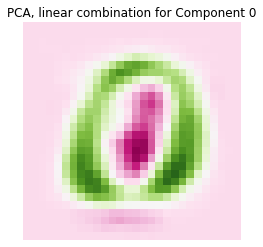

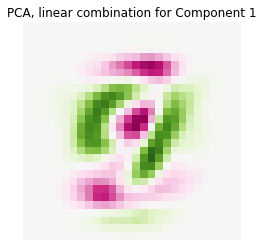

In [7]:
# Lets have a look at what features/pixels were used the most by our two PCA components:
for i in [0,1]:
    plt.imshow(pca.components_[i].reshape(28,28), cmap="PiYG")
    plt.title("PCA, linear combination for Component " + str(i))
    plt.axis("off")
    plt.show()

# There are a lot of pixels with no to only a bit of weight, so we could do feature selection and simply neglect pixels
# e.g. in the corners of the images

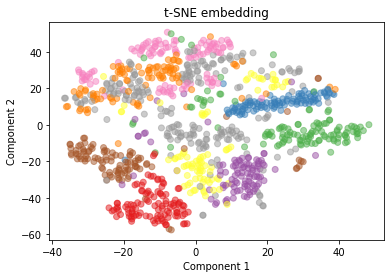

In [8]:
# Next, we visualize the t-SNE embedding. The desirable outcome here would be to have compact non-overlapping
# clusters of classes. This plot might already foreshadow - to some extent - how complicated the classification
# task will be
view = TSNE(n_components=2, random_state=0).fit_transform(train_X)
#plt.figure(figsize=(20,10))
plt.scatter(view[:,0], view[:,1], c=train_Y, alpha=0.5, cmap="Set1")
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.title("t-SNE embedding")
plt.show()

kNN scores:  [0.93839286 0.93377976 0.92827381 0.93735119 0.93407738]
SVM scores:  [0.94166667 0.93199405 0.93214286 0.93467262 0.93377976]


/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and th

MLP scores:  [0.96547619 0.95863095 0.959375   0.9610119  0.96339286]
DecisionTree scores:  [0.69791667 0.67261905 0.67752976 0.68005952 0.67485119]
RandomForest scores:  [0.81636905 0.79702381 0.81592262 0.81666667 0.80252976]
AdaBoost scores:  [0.68571429 0.70803571 0.72276786 0.69970238 0.71949405]


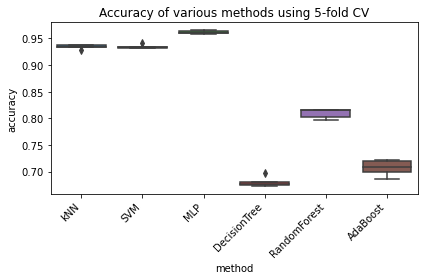

In [9]:
""" MAIN CLASSIFICATION PIPELINES """
train_Y = train_data[:, 0]
train_X = train_data[:, 1:]

# Split train set into train and validation
train_inds, val_inds = sklearn.model_selection.train_test_split(
    np.arange(len(train_Y)), test_size=0.2
)
train_X, val_X = train_X[train_inds], train_X[val_inds]
train_Y, val_Y = train_Y[train_inds], train_Y[val_inds]

# Try several classifiers using kFold CrossValidation
performances = utils.boilerplates.run_several_classifiers(train_X, train_Y, cv=True)

# Lets report their performances
chart = sns.boxplot(x="method", y="accuracy", data=performances)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.title("Accuracy of various methods using 5-fold CV")
plt.tight_layout()
plt.show()

kNN scores:  [0.5        0.57692308 0.61538462 0.72       0.6       ]
SVM scores:  [0.76923077 0.76923077 0.73076923 0.72       0.8       ]


/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and th

MLP scores:  [0.65384615 0.5        0.46153846 0.6        0.76      ]
DecisionTree scores:  [0.38461538 0.42307692 0.42307692 0.56       0.48      ]
RandomForest scores:  [0.42307692 0.53846154 0.5        0.48       0.6       ]
AdaBoost scores:  [0.19230769 0.11538462 0.30769231 0.36       0.08      ]
kNN scores:  [0.71153846 0.74509804 0.64705882 0.7254902  0.78431373]
SVM scores:  [0.76923077 0.92156863 0.84313725 0.88235294 0.88235294]


/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and th

MLP scores:  [0.61538462 0.62745098 0.60784314 0.68627451 0.60784314]
DecisionTree scores:  [0.53846154 0.45098039 0.52941176 0.49019608 0.60784314]
RandomForest scores:  [0.59615385 0.74509804 0.64705882 0.64705882 0.58823529]
AdaBoost scores:  [0.15384615 0.19607843 0.29411765 0.29411765 0.25490196]
kNN scores:  [0.78640777 0.75728155 0.74509804 0.75490196 0.70588235]
SVM scores:  [0.86407767 0.83495146 0.89215686 0.88235294 0.83333333]


/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and th

MLP scores:  [0.74757282 0.74757282 0.74509804 0.79411765 0.76470588]
DecisionTree scores:  [0.57281553 0.60194175 0.6372549  0.58823529 0.59803922]
RandomForest scores:  [0.74757282 0.7184466  0.69607843 0.71568627 0.7745098 ]
AdaBoost scores:  [0.29126214 0.32038835 0.29411765 0.29411765 0.48039216]
kNN scores:  [0.80487805 0.84390244 0.8097561  0.84878049 0.84313725]
SVM scores:  [0.87804878 0.92195122 0.88292683 0.88780488 0.8872549 ]


/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/florian/.conda/envs/py36/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:617: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and th

MLP scores:  [0.82926829 0.86341463 0.88780488 0.84390244 0.84803922]
DecisionTree scores:  [0.62439024 0.63414634 0.66829268 0.62926829 0.60294118]
RandomForest scores:  [0.74634146 0.7902439  0.8195122  0.82439024 0.76960784]
AdaBoost scores:  [0.28780488 0.40487805 0.47804878 0.30731707 0.4754902 ]


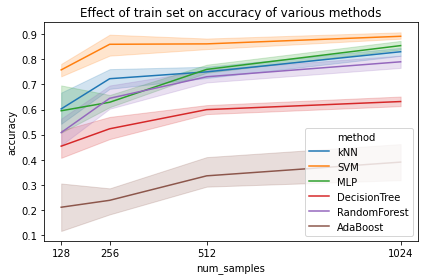

In [10]:
# Also, its interesting to see how well the classifiers do with less data
all_perfs = pd.DataFrame(columns=["method", "balanced_accuracy", "num_samples"])
possible_samples = [128, 256, 512, 1024]
for samples in possible_samples:
    performances = utils.boilerplates.run_several_classifiers(train_X[:samples], train_Y[:samples], cv=True)
    performances["num_samples"] = samples
    all_perfs = all_perfs.append(performances)

chart = sns.lineplot(x="num_samples", y="accuracy", hue="method", data=all_perfs)
#chart.set_xticklabels(possible_samples)
chart.set_xticks(possible_samples)
chart.set_xticklabels(possible_samples)
plt.title("Effect of train set on accuracy of various methods")
plt.tight_layout()
plt.show()

MLP Val accuracy: 0.9580952380952381


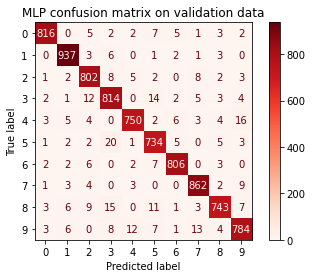

In [11]:
# Lets train an MLP (as they scale better than SVMs with the amount of training data)
clf = MLPClassifier()
clf.fit(train_X, train_Y)
pred = clf.predict(val_X)
score = sklearn.metrics.accuracy_score(val_Y, pred)
print("MLP Val accuracy: " + str(score))

# Plot confusion matrix of best classifier
sklearn.metrics.plot_confusion_matrix(clf,
                      val_X,
                      val_Y,
                      cmap="Reds")
plt.title("MLP confusion matrix on validation data")
plt.show()

Epoch: 0 	 Test Accuracy: 91.2%, Avg loss: 0.034560
Epoch: 1 	 Test Accuracy: 93.7%, Avg loss: 0.025251
Epoch: 2 	 Test Accuracy: 94.2%, Avg loss: 0.022043
Epoch: 3 	 Test Accuracy: 95.1%, Avg loss: 0.019355
Epoch: 4 	 Test Accuracy: 94.9%, Avg loss: 0.020481
Epoch: 5 	 Test Accuracy: 95.8%, Avg loss: 0.016725
Epoch: 6 	 Test Accuracy: 95.9%, Avg loss: 0.015878
Epoch: 7 	 Test Accuracy: 95.5%, Avg loss: 0.017369
Epoch: 8 	 Test Accuracy: 96.0%, Avg loss: 0.014684
Epoch: 9 	 Test Accuracy: 96.3%, Avg loss: 0.014531


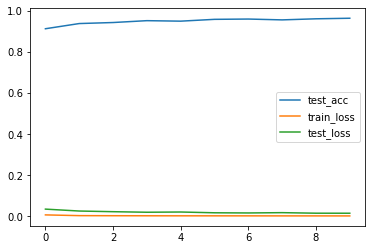

In [12]:
# Lets leverage the local spatial relations of the input data and use a 2D CNN
train_dataset = utils.dataset.MNISTDataset(train_X, train_Y)
val_dataset = utils.dataset.MNISTDataset(val_X, val_Y)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = utils.models.MNIST_CNN_01().to(device)
optimizer = torch.optim.Adam(cnn.parameters(), lr=0.001)
utils.boilerplates.train_classifier(
    cnn, optimizer, train_loader, device, 10, nn.CrossEntropyLoss(), val_loader, show_plot=True
)

In [14]:
# We could do some hyperparameter tuning now by doing GridSearch, however I rather want to check out
# one particular Neural Network that I worked with during my PhD: Capsule Networks
capsule_net = capsules.CapsuleNetwork().to(device)
criterion = capsules.CapsuleLoss()
optimizer = optim.Adam(capsule_net.parameters())

def train(capsule_net, criterion, optimizer, n_epochs=10, print_every=300):
    losses = []
    for epoch in range(1, n_epochs):
        train_loss = 0.0
        capsule_net.train()
        for batch_i, (images, target) in tqdm(enumerate(train_loader)):
            target = torch.eye(10).index_select(dim=0, index=target)
            images, target = images.to(device), target.to(device)
            optimizer.zero_grad()
            caps_output, reconstructions, y = capsule_net(images)
            loss = criterion(caps_output, target, images, reconstructions)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if batch_i != 0 and batch_i % print_every == 0:
                avg_train_loss = train_loss/print_every
                losses.append(avg_train_loss)
                print('Epoch: {} \tTraining Loss: {:.8f}'.format(epoch, avg_train_loss))
                train_loss = 0
        if epoch % 1 == 0:
            out = []
            gt = []
            capsule_net.eval()
            for image, target in tqdm(val_loader):
                image = image.to(device)
                caps_out, reconstructed, y = capsule_net(image)
                _, pred = torch.max(y.data.cpu(), 1)
                out.extend(pred.numpy().tolist())
                gt.extend(target.numpy().tolist())

            print("Test Accuracy:", sklearn.metrics.accuracy_score(gt, out))

    return losses

losses = train(capsule_net, criterion, optimizer, n_epochs=10)

/home/florian/.conda/envs/py36/lib/python3.6/site-packages/torch/nn/_reduction.py:44: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
263it [00:39,  6.60it/s]
100%|██████████| 1050/1050 [00:11<00:00, 93.48it/s]
1it [00:00,  6.32it/s]

Test Accuracy: 0.895


263it [00:40,  6.46it/s]
100%|██████████| 1050/1050 [00:11<00:00, 91.98it/s]
1it [00:00,  6.48it/s]

Test Accuracy: 0.9278571428571428


263it [00:41,  6.30it/s]
100%|██████████| 1050/1050 [00:11<00:00, 91.03it/s]
1it [00:00,  6.54it/s]

Test Accuracy: 0.9357142857142857


263it [00:40,  6.55it/s]
100%|██████████| 1050/1050 [00:10<00:00, 96.57it/s]
1it [00:00,  6.79it/s]

Test Accuracy: 0.9357142857142857


263it [00:38,  6.76it/s]
100%|██████████| 1050/1050 [00:10<00:00, 96.49it/s]
1it [00:00,  6.73it/s]

Test Accuracy: 0.9458333333333333


263it [00:38,  6.75it/s]
100%|██████████| 1050/1050 [00:10<00:00, 96.07it/s]
1it [00:00,  6.78it/s]

Test Accuracy: 0.9510714285714286


263it [00:39,  6.64it/s]
100%|██████████| 1050/1050 [00:11<00:00, 88.80it/s]
1it [00:00,  6.17it/s]

Test Accuracy: 0.9538095238095238


263it [00:41,  6.38it/s]
100%|██████████| 1050/1050 [00:11<00:00, 90.16it/s]
1it [00:00,  6.40it/s]

Test Accuracy: 0.9532142857142857


263it [00:40,  6.50it/s]
100%|██████████| 1050/1050 [00:11<00:00, 89.99it/s]

Test Accuracy: 0.9539285714285715
